In [52]:
import pyodbc
import pandas as pd

# Configuración de conexión
conn_str = 'DRIVER={ODBC Driver 17 for SQL Server};SERVER=localhost;DATABASE=dwh_case1;Trusted_Connection=yes;TrustServerCertificate=yes'

# Crear conexión
conn = pyodbc.connect(conn_str)

# Escribir la consulta SQL
query = """
    SELECT 
        fact.PVP,
        AVG(fact.Car_Age) AS avg_car_age,
        AVG(fact.Km_medio_por_revision) AS avg_km_revision,
        AVG(ISNULL(fact.Revisiones, 0)) AS avg_revisiones,
        AVG(CAST(churn AS FLOAT)) AS churn_percentage
    FROM DATAEX.FACT_SALES fact
    GROUP BY fact.PVP;
"""

# Ejecutar la consulta y cargar los datos en un DataFrame
df = pd.read_sql(query, conn)


# Mostrar las primeras filas del DataFrame
print(df.head())


     PVP  avg_car_age  avg_km_revision  avg_revisiones  churn_percentage
0  21818     1.979167            25912               1          0.583333
1  22814     2.063492            22100               0          0.238095
2  28719     1.666667            14652               1          0.333333
3  31968     3.166667            39917               2          0.833333
4  17550     1.962617            22680               1          0.481308


C:\Users\josit\AppData\Local\Temp\ipykernel_25632\3926100549.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [53]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Definir variables predictoras (X) y la variable objetivo (y)
X = df[['PVP', 'avg_car_age', 'avg_km_revision', 'avg_revisiones']]
y = df['churn_percentage']

# Dividir en conjunto de entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

# Mostrar coeficientes del modelo
coef_df = pd.DataFrame({'Variable': X.columns, 'Coeficiente': model.coef_})
print(coef_df)


Mean Squared Error (MSE): 0.027638148135328264
R² Score: 0.6773953335989813
          Variable  Coeficiente
0              PVP     0.000008
1      avg_car_age    -0.070765
2  avg_km_revision     0.000016
3   avg_revisiones     0.118480


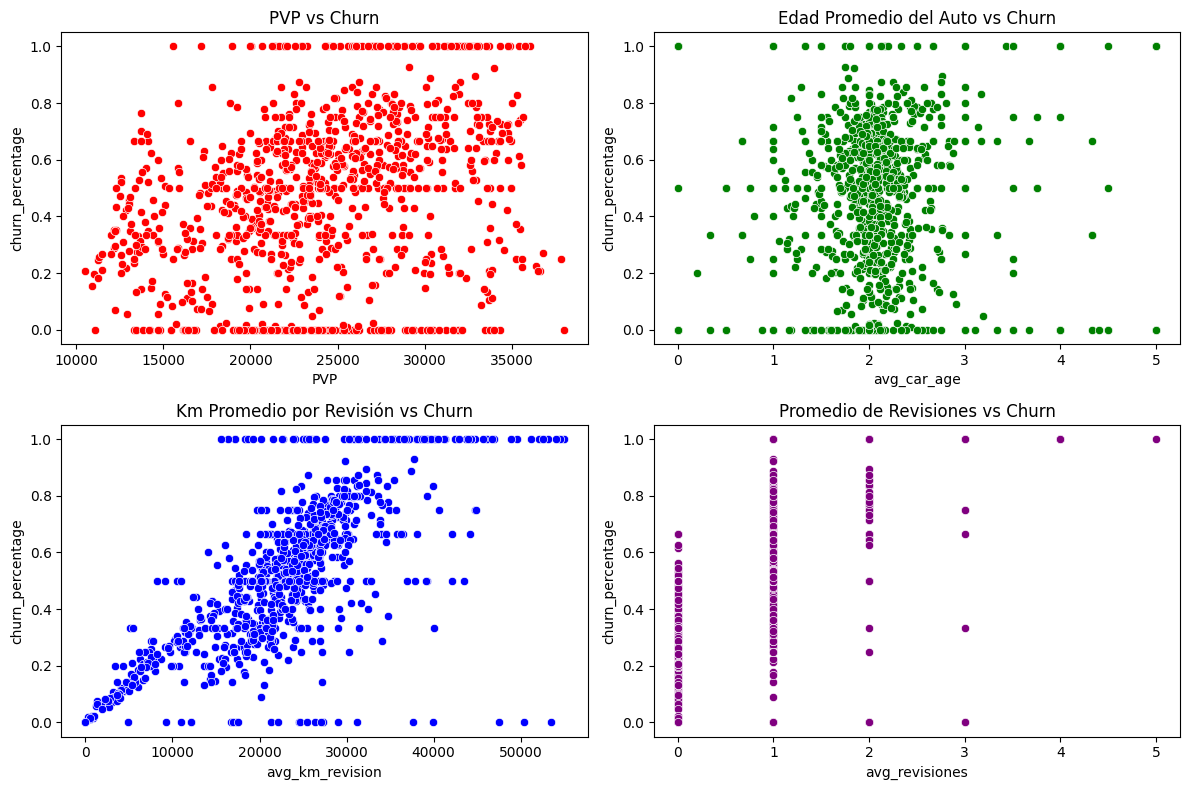

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt


fig, axes = plt.subplots(2, 2, figsize=(12, 8))

sns.scatterplot(x=df["PVP"], y=df["churn_percentage"], ax=axes[0, 0], color="red")
axes[0, 0].set_title("PVP vs Churn")

sns.scatterplot(x=df["avg_car_age"], y=df["churn_percentage"], ax=axes[0, 1], color="green")
axes[0, 1].set_title("Edad Promedio del Auto vs Churn")

sns.scatterplot(x=df["avg_km_revision"], y=df["churn_percentage"], ax=axes[1, 0], color="blue")
axes[1, 0].set_title("Km Promedio por Revisión vs Churn")

sns.scatterplot(x=df["avg_revisiones"], y=df["churn_percentage"], ax=axes[1, 1], color="purple")
axes[1, 1].set_title("Promedio de Revisiones vs Churn")

plt.tight_layout()
plt.show()


In [55]:
# Obtener las predicciones de churn usando el modelo entrenado
y_pred = model.predict(df[['PVP', 'avg_car_age', 'avg_km_revision', 'avg_revisiones']])

# Añadir las predicciones al DataFrame para comparación
df['churn_predicho'] = y_pred

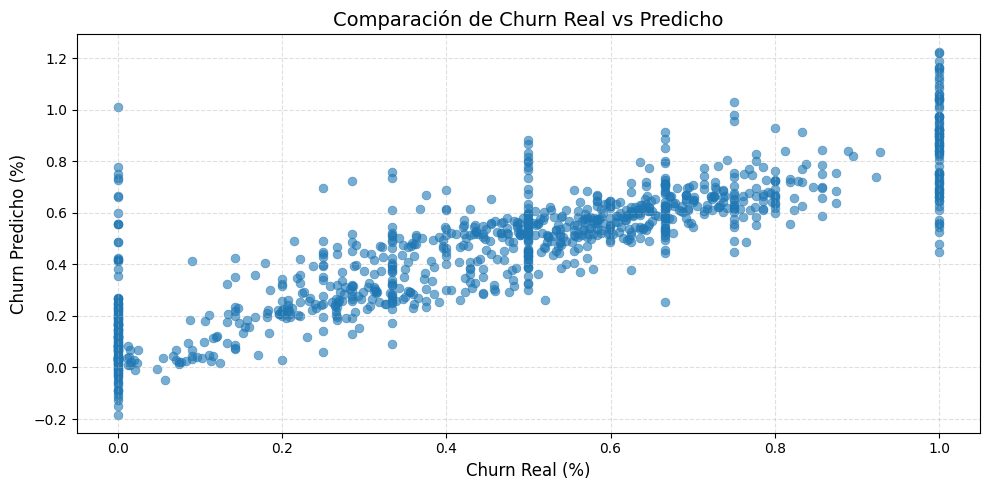

In [56]:
# Obtener las predicciones de churn usando el modelo entrenado
y_pred = model.predict(df[['PVP', 'avg_car_age', 'avg_km_revision', 'avg_revisiones']])

# Añadir las predicciones al DataFrame para comparación
df['churn_predicho'] = y_pred

# Crear el gráfico de dispersión
plt.figure(figsize=(10, 5))

# Graficar el churn real vs el churn predicho
sns.scatterplot(x=df['churn_percentage'], y=df['churn_predicho'], alpha=0.6, s=40, edgecolor=None)

# Etiquetas y título
plt.xlabel("Churn Real (%)", fontsize=12)
plt.ylabel("Churn Predicho (%)", fontsize=12)
plt.title("Comparación de Churn Real vs Predicho", fontsize=14)

# Personalizar el gráfico
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()

# Mostrar el gráfico
plt.show()


In [57]:
coef_df = pd.DataFrame({
    'Variable': X.columns.tolist() + ['Intercepto'],
    'Coeficiente': model.coef_.tolist() + [model.intercept_]
})

print("Coeficientes estimados:")
display(coef_df)

Coeficientes estimados:


,Variable,Coeficiente
0,PVP,0.000008
1,avg_car_age,-0.070765
2,avg_km_revision,0.000016
3,avg_revisiones,0.118480
4,Intercepto,0.005233


In [ ]:
cursor = conn.cursor()
table = "churn_coef"

# Creación de la tabla.
cursor.execute(f"""
IF NOT EXISTS (SELECT * FROM sysobjects WHERE name='{table}' AND xtype='U')
CREATE TABLE {table} (
    Variable NVARCHAR(50) PRIMARY KEY,
    Coeficiente FLOAT
)
""")

# Vacio de la tabla antes de insertar nuevos coeficientes.
cursor.execute(f"DELETE FROM {table}")

# Inserción de coeficientes en la tabla.
insert_sql = f"INSERT INTO {table} (Variable, Coeficiente) VALUES (?, ?)"
for _, row in coef_df.iterrows():
    cursor.execute(insert_sql, row['Variable'], row['Coeficiente'])

conn.commit()
conn.close()
print(f"Tabla '{table}' creada y poblada correctamente.")


Tabla 'churn_coef' creada y poblada correctamente.


ProgrammingError: Attempt to use a closed connection.